In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
# import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.preprocessing import normalize

In [2]:
def read_textfiles(path):
    poss_columns = ['Lenkradwin', 'Lenkmoment', 'Fahrgeschw', 'Querbeschl', 'Giergeschw', 'Wankwinkel', 'Radius']
    files = sorted(os.listdir(path))
    print("No. of files to be processed are: ", len(files))
    count  = 0
    data = []
    dup_path = path
    for each_file in files:
        dup_path += each_file
#         print(dup_path)
        print(count, end=',')
#         data.append(pd.read_csv(dup_path, sep = '\t', engine = 'python', decimal = ',', skiprows = 40, usecols = poss_columns)[2: ].apply(pd.to_numeric))
        data.append(pd.read_csv(dup_path, sep = '\t', engine = 'python', decimal = ',', skiprows = 40)[2: ].apply(pd.to_numeric))
        count += 1
        dup_path = path
    print("No. of files processed are: ", count)
    return data

In [9]:
file_data = read_textfiles('/home/loki/MAS/R_D/Moses/Full_data/sk_folded/0031678-8801103(001)/')

No. of files to be processed are:  6
0,1,2,3,4,5,No. of files processed are:  6


In [10]:
removable_columns = ['L�ngsbesch', 'GPS_Status', 'Status_DIS', 'Status_TRK', 'GPS_FMS_St','Breitengrd', 'L�ngengrad', 
                     'Breitengrd', 'H�he', 'Fahrg_NULL', 'StWhl_AnglSpd', 'Odo', 'AirTemp_Outsd_Disp', 'AirTemp_Outsd',
                     'BrkPdl_Stat', 'Brk_Stat', 'FullBrk_Actv', 'BrkIntrvntn_Actv_ESP', 'ESP_CtrlLmp_Info',
                     'AccelPdlPosn_Raw', 'AccelPdlPosn', 'KickDnSw_Psd',  'TankLvl', 'TankLvl_Disp_V2', 'SupBat_Volt', 
                     'SupBat_Curr', 'StW_Trq_EPS', 'EPS_FtWhlAngl', 'EPS_FtWhlAngl_Offset', 'VehAccel_X_Offset',
                      'VehYawRateOffset_V2', 'BrkTrq_V2']
for each_file in range(len(file_data)):
    file_data[each_file] = file_data[each_file].drop(columns=removable_columns)

In [15]:
file_merged_data = np.asarray(pd.concat(file_data))
# file_merged_data = file_merged_data.T
row, col = file_merged_data.shape
# sequence = file_merged_data

In [19]:
normalized_data = normalize(file_merged_data, axis = 0)
sequence = normalized_data.reshape((row, 1, col))
print(sequence.shape)

(67468, 1, 32)


In [6]:
def train_generator():
    while True:
        sequence_length = np.random.randint(10, 100)
        x_train = np.random.random((1000, sequence_length, 5))
        # y_train will depend on past 5 timesteps of x
        y_train = x_train[:, :, 0]
        for i in range(1, 5):
            y_train[:, i:] += x_train[:, :-i, i]
        y_train = to_categorical(y_train > 2.5)
        yield x_train, y_train

x = train_generator()
for enum, i in enumerate(x):
    print(i[0].shape)
#     print(i[0])
#     print(i[1].shape)
    if enum == 0:
        break

(1000, 98, 5)


In [7]:
reshapes = []
for i in file_data:
    files = np.asarray(i)
    row, col = files.shape
    files = files.reshape((row, 1, col))
    reshapes.append(files)
for i in range(len(reshapes)):
    print(reshapes[i].shape)

(12520, 1, 7)
(12164, 1, 7)
(11352, 1, 7)
(10112, 1, 7)
(11112, 1, 7)
(10208, 1, 7)


In [21]:

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(None,32), return_sequences=True))
model.add(LSTM(7, activation='relu', return_sequences=True, activity_regularizer=regularizers.l1(0.01)))
model.add(LSTM(2, activation='relu', return_sequences=True, activity_regularizer=regularizers.l1(0.01)))
# model.add(RepeatVector(None))
model.add(LSTM(7, activation='relu', return_sequences=True, activity_regularizer=regularizers.l1(0.01)))
model.add(LSTM(32, activation='relu', return_sequences=True, activity_regularizer=regularizers.l1(0.01)))
model.add(TimeDistributed(Dense(32, activation='tanh')))
# model.add(LSTM(32, return_sequences=True, input_shape=(None, 7)))
# model.add(LSTM(8, return_sequences=True))
# model.add(TimeDistributed(Dense(7, activation='sigmoid')))
model.compile(optimizer='adam', loss='mse', metrics = ['acc'])

model2 = Sequential()
model2.add(LSTM(4, activation='relu', input_shape=(None,7), return_sequences=True))
model2.add(LSTM(2, activation='relu', return_sequences=True))
# model.add(RepeatVector(None))
model2.add(LSTM(2, activation='relu', return_sequences=True))
model2.add(LSTM(4, activation='relu', return_sequences=True))
model2.add(TimeDistributed(Dense(7)))
# model.add(LSTM(32, return_sequences=True, input_shape=(None, 7)))
# model.add(LSTM(8, return_sequences=True))
# model.add(TimeDistributed(Dense(7, activation='sigmoid')))
model2.compile(optimizer='adam', loss='mse', metrics = ['acc'])

# for enum, i in enumerate(reshapes):
#     if enum%2 == 0:
#         print("Right testrun")
#         model.fit(i, i, epochs = 1)
#     else:
#         print("Left testrun")
#         model2.fit(i, i, epochs = 1)
model.fit(sequence, sequence, epochs = 5, shuffle = False)#, validation_data = (reshapes[2], reshapes[2]))

Train on 67468 samples
Epoch 1/5
67468/67468 [==============================] - 101s 2ms/sample - loss: 2.9236e-06 - acc: 0.4845
Epoch 2/5
67468/67468 [==============================] - 86s 1ms/sample - loss: 3.0603e-06 - acc: 0.4759
Epoch 3/5
26752/67468 [==========>...................] - ETA: 46s - loss: 3.0982e-06 - acc: 0.4415

KeyboardInterrupt: 

In [9]:
y = model.predict(reshapes[0])

In [4]:
from sklearn.decomposition import PCA

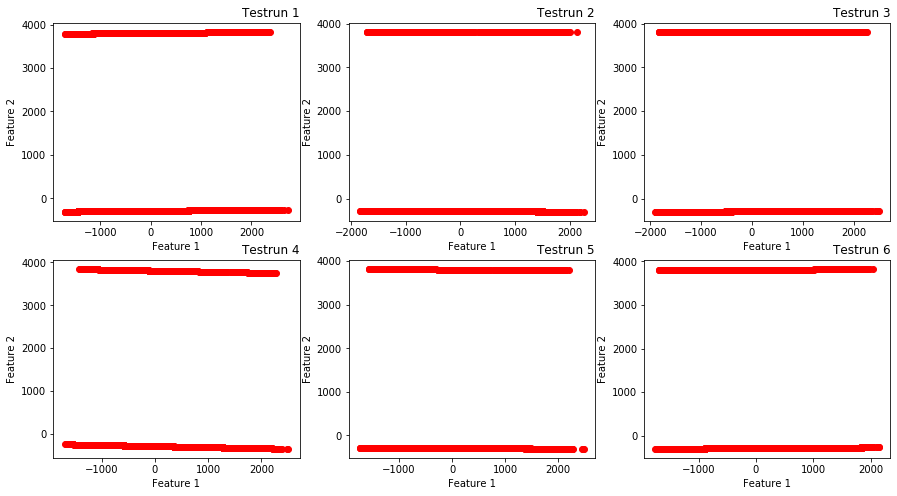

In [6]:
plt.figure(figsize=(15,8))
for i in range(len(file_data)):
    pca = PCA(n_components=2)
    pca.fit(file_data[i])
    y = pca.transform(file_data[i])
    plt.subplot(2, 3, i+1)
    plt.scatter(y[:, 0:1], y[:, 1:2], c='r')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    title_run = "Testrun "+str(i+1)
    plt.title(title_run, loc='right')

plt.savefig('/home/loki/pca.png')
plt.show()

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
rf_data = file_data[0]
label = rf_data['Radius']
rf_data = rf_data.drop(columns=['Radius'])
rf = RandomForestRegressor()
rf.fit(rf_data, label)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

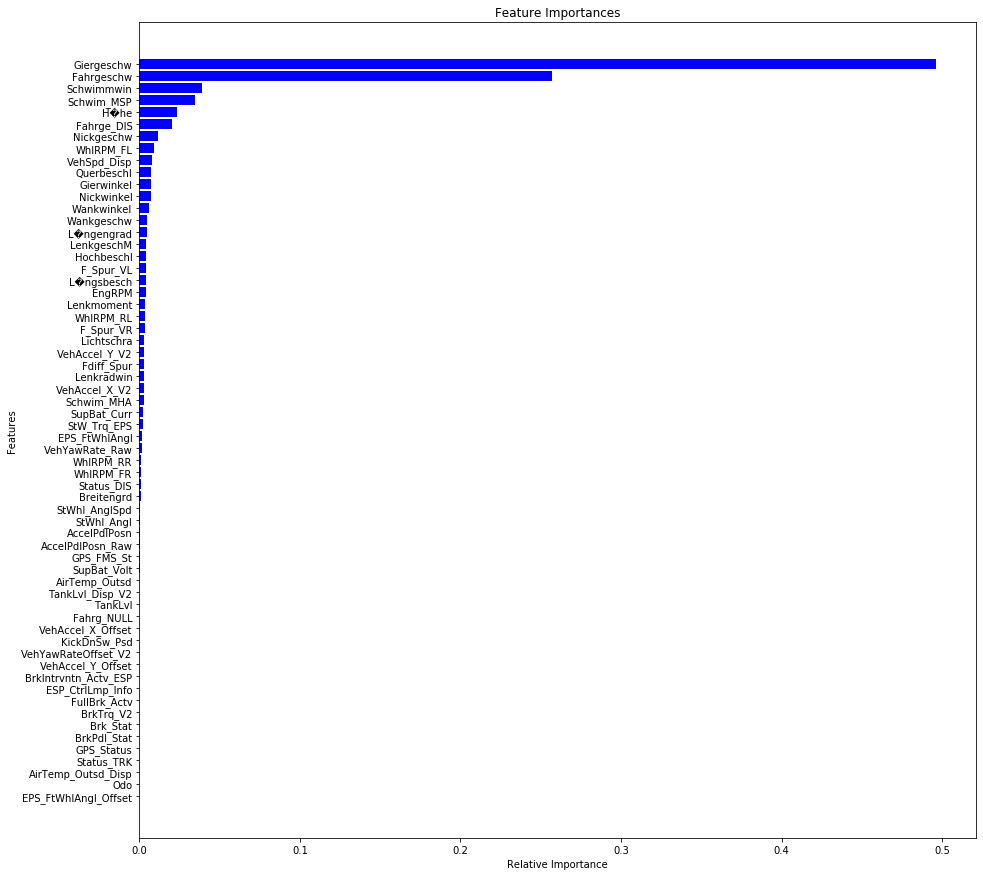

In [30]:
features = list(rf_data.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,15))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.savefig('RF_import_features.png')
plt.show()